<a href="https://colab.research.google.com/github/eafpres/dogs_cats_sklearn/blob/master/Exercise_1_01_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cats and Dogs data from:  
https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765  
This example uses only the first 300 images each of cats and dogs  
  
![](https://drive.google.com/uc?id=1V1hIjUrDNwWd2b9-Q1-3JkVKWpKFSmgA)  
  
![](https://drive.google.com/uc?id=19EZLiwR-TGRcNvoojRfrpFfPRgcASBQW)  


In [0]:
import time
import numpy as np
import pandas as pd
from numpy import random
%matplotlib inline
from matplotlib import pyplot as plt
from skimage import data, color
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

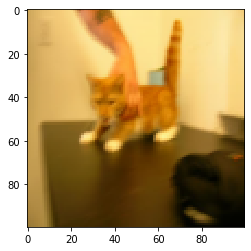

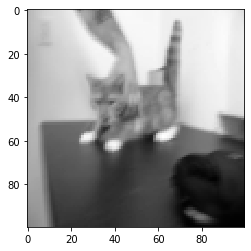

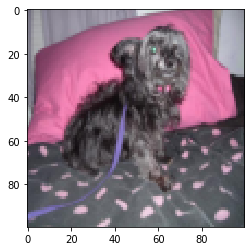

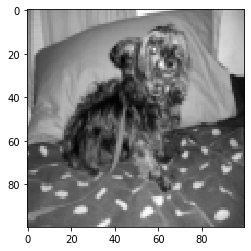

In [3]:
#
# load one example cat
#
file_id = '19EZLiwR-TGRcNvoojRfrpFfPRgcASBQW'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.jpg')
cat = plt.imread('Filename.jpg')
#
# for training, we need all images the same size
# this is not an optimal size necessarily
#
cat = resize(cat, 
             (100, 100),
             anti_aliasing = True)
plt.imshow(cat)
plt.show()
#
# for this exercise, we will convert to grayscale
# this is also not optimal necessarily
#
cat = rgb2gray(cat)
plt.imshow(cat, cmap = plt.cm.gray)
plt.show()
#
# load one example dog
#
file_id = '1V1hIjUrDNwWd2b9-Q1-3JkVKWpKFSmgA'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.jpg')
dog = plt.imread('Filename.jpg')
dog = resize(dog,
             (100, 100),
             anti_aliasing = True)
plt.imshow(dog)
plt.show()
dog = rgb2gray(dog)
plt.imshow(dog, cmap = plt.cm.gray)
plt.show()

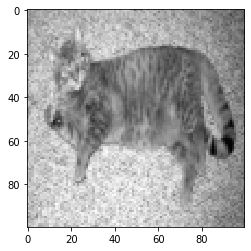

In [4]:
#cats_dir = '1qfkm9QYoHEB-YEHlO1DgsJH6CjXaLLA7'
#
# load the cats
# get the list, then look at first one
#
cat_file_list = drive.ListFile(
    {'q' : "'1qfkm9QYoHEB-YEHlO1DgsJH6CjXaLLA7' in parents"}).GetList()
my_cat = cat_file_list[0]
this_cat_file = drive.CreateFile({'id' : my_cat['id']}) 
this_cat_file.GetContentFile('Filename.jpg')
this_cat = rgb2gray(resize(plt.imread('Filename.jpg'), (100, 100)))
plt.imshow(this_cat, cmap = plt.cm.gray)
plt.show()
cats = dict({0 : this_cat})

In [0]:
#
# load the rest of the cats
#
count = 1
for my_cat in cat_file_list[1:300]:
    time.sleep(1)
    this_cat_file = drive.CreateFile({'id' :  my_cat['id']}) 
    this_cat_file.GetContentFile('Filename.jpg')
    this_cat = rgb2gray(resize(plt.imread('Filename.jpg'), (100, 100)))
    cats[count] = this_cat
    count += 1

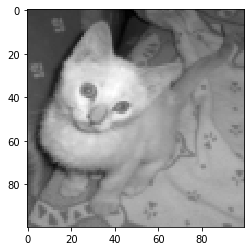

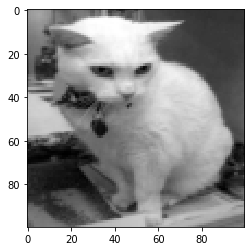

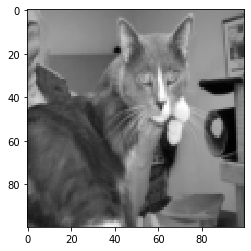

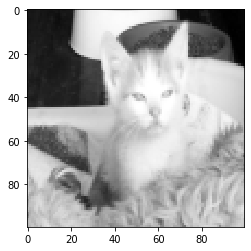

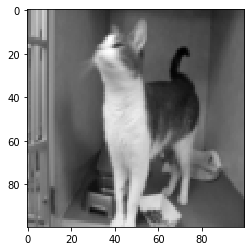

In [5]:
#
# inspect a few random samples
#
cat_samples = random.randint(0, len(cats), 5)
for i in cat_samples:
  plt.imshow(cats[i], cmap = plt.cm.gray)
  plt.show()

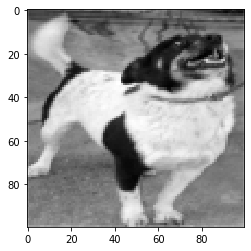

In [76]:
#dogs_dir = '1jYekYnT29ZaejEPsh--jVet6FgI-AwK6'
#
# load the dogs
# get the list, then look at first one
#
dog_file_list = drive.ListFile(
    {'q' : "'1jYekYnT29ZaejEPsh--jVet6FgI-AwK6' in parents"}).GetList()
my_dog = dog_file_list[0]
this_dog_file = drive.CreateFile({'id' : my_dog['id']}) 
this_dog_file.GetContentFile('Filename.jpg')
this_dog = rgb2gray(resize(plt.imread('Filename.jpg'), (100, 100)))
plt.imshow(this_dog, cmap = plt.cm.gray)
plt.show()
dogs = dict({0 : this_dog})

In [0]:
#
# load remaining dogs
#
count = 1
for my_dog in dog_file_list[1:300]:
  time.sleep(1)
  this_dog_file = drive.CreateFile({'id' :  my_dog['id']}) 
  this_dog_file.GetContentFile('Filename.jpg')
  this_dog = rgb2gray(resize(plt.imread('Filename.jpg'), (100, 100)))
  dogs[count] = this_dog
  count += 1

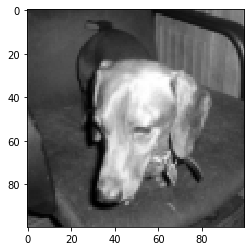

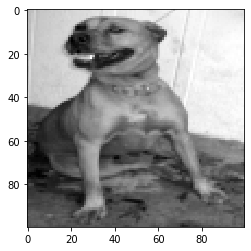

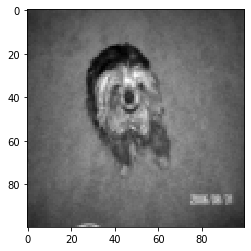

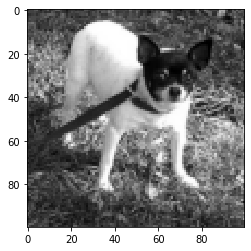

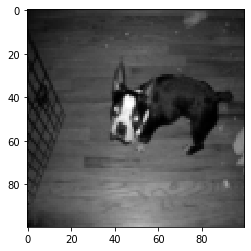

In [78]:
#
# inspect a few random samples
#
dog_samples = random.randint(0, len(dogs), 5)
for i in dog_samples:
  plt.imshow(dogs[i], cmap = plt.cm.gray)
  plt.show()

In [0]:
#
# flatten
# this step "unwraps" the 2D image into a 1 D vector
#
cats_data = {i : cats[i].flatten() for (i, cats[i]) in cats.items()}
dogs_data = {i : dogs[i].flatten() for (i, dogs[i]) in dogs.items()}

In [0]:
#
# test to see if there are any bad images
#
cats_sums = [sum(cats_data[i]) for i in range(len(cats_data))]
dogs_sums = [sum(dogs_data[i]) for i in range(len(dogs_data))]

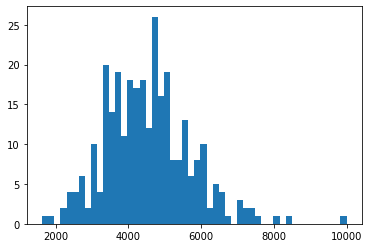

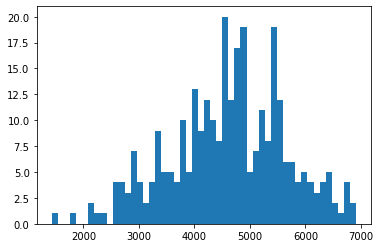

<Figure size 432x288 with 0 Axes>

In [82]:
plt.hist(cats_sums, bins = 50)
plt.show()
plt.clf()
plt.hist(dogs_sums, bins = 50)
plt.show()
plt.clf()

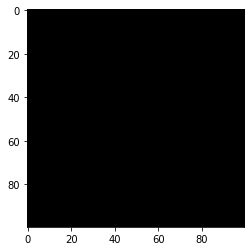

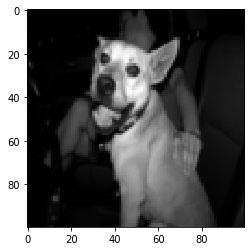

In [84]:
#
# one cat is an all black image (sum = 10000)
# let's remove that
#
bad_cat = cats_sums.index(max(cats_sums))
plt.imshow(cats[bad_cat], cmap = plt.cm.gray)
plt.show()
#
# let's also look at the dog with the lowest sum
#
question_dog = dogs_sums.index(min(dogs_sums))
plt.imshow(dogs[question_dog], cmap = plt.cm.gray)
plt.show()

In [0]:
#
# remove the bad cat
#
del cats_data[bad_cat]

In [0]:
#
# put the data into the right form for the classifier
# and add labels 1 = cat, 0 = dog
#
cats_array = np.array([cats_data[i] for i in cats_data.keys()])
cats_labels = np.ones(cats_array.shape[0])
dogs_array = np.array([dogs_data[i] for i in dogs_data.keys()])
dogs_labels = np.zeros(dogs_array.shape[0])
#
# split a validation set (and shuffle, by default)
#
train_data, val_data, train_labels, val_labels = \
  train_test_split(np.concatenate((cats_array, dogs_array), axis = 0),
                   np.concatenate((cats_labels, dogs_labels)),
                   test_size = 0.2)

In [91]:
#
# train a logistic regression classifier
#
logisticRegr = LogisticRegression(max_iter = 10000, 
                                  tol = 0.000001,
                                  solver = 'liblinear')
logisticRegr.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=1e-06, verbose=0,
                   warm_start=False)

In [95]:
#
# make predictions
#
predictions = logisticRegr.predict(val_data)
val_errs = ([abs(predictions[i] - val_labels[i]) for i in range(len(predictions))])
print('val accuracy = ', 100 * (1 - (sum(errs) / len(predictions))))
predictions = logisticRegr.predict(train_data)
train_errs = ([abs(predictions[i] - train_labels[i]) for i in range(len(predictions))])
print('train accuracy = ', 100 * (1 - (sum(errs) / len(predictions))))

val accuracy =  62.5
train accuracy =  90.6054279749478


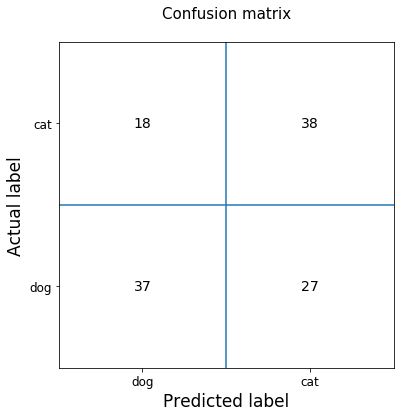

In [94]:
#
# evaluate the model using a confusion matrix
#
cm = metrics.confusion_matrix(val_labels, predictions)
#
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.set_title('Confusion matrix\n', size = 15)
tick_marks = [0.5, 1.5]
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks(tick_marks)
ax.set_xticklabels(('dog', 'cat'))
ax.set_yticks(tick_marks)
ax.set_yticklabels(('dog', 'cat'))
ax.set_ylabel('Actual label', size = 17)
ax.set_xlabel('Predicted label', size = 17)
ax.tick_params(labelsize = 12)
ax.axvline(x = 1, ymin = 0, ymax = 2)
ax.axhline(y = 1, xmin = 0, xmax = 2)
#
for x in [0, 1]:
  for y in [0, 1]:
    ax.annotate(str(cm[x][y]), xy = (x + 0.5, y + 0.5),
                horizontalalignment = 'center',
                verticalalignment = 'center',
                fontsize = 14)

The result is we achieve over 90% accuracty on the training data but only 62.5% on the validation data.  If this were a real business problem we would investigate options to improve the validation performance, including many parameters for the logistic regression classifier, as well as considering using the RGB images instead of gray scale.  For now, we will leave this example and move on.